# **About Dataset**

I use the 20 Newsgroups dataset taken from scikit-learn. This dataset contains posts from 20 different newsgroups and covers many topics like politics, religion, sports, science, and technology.

# **Task**

This project addresses the problem of multi-class text classification using the 20 Newsgroups dataset. The objective is to evaluate and compare different text representation methods (Bag-of-Words, TF-IDF, and Word2Vec) for classifying documents into topic categories. The study includes data cleaning, preprocessing, exploratory data analysis, model training, and evaluation using standard classification metrics. The task is not related to spam detection.

In [ ]:
!pip install gensim
from sklearn.datasets import fetch_20newsgroups
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from gensim.models import Word2Vec
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from IPython.display import display

# Fetching the complete 20 Newsgroups dataset
newsgroup_data = fetch_20newsgroups(subset="all")
news_df = pd.DataFrame({
    "text": newsgroup_data.data,
    "label_id": newsgroup_data.target
})
news_df["label"] = news_df["label_id"].apply(lambda idx: newsgroup_data.target_names[idx])
print(news_df.head())

                                                text  label_id                     label
0  From: Mamatha Devineni Ratnam <mr47+@andrew.cm...        10          rec.sport.hockey
1  From: mblawson@midway.ecn.uoknor.edu (Matthew ...         3  comp.sys.ibm.pc.hardware
2  From: hilmi-er@dsv.su.se (Hilmi Eren)\nSubject...        17     talk.politics.mideast
3  From: guyd@austin.ibm.com (Guy Dawson)\nSubjec...         3  comp.sys.ibm.pc.hardware
4  From: Alexander Samuel McDiarmid <am2o+@andrew...         4     comp.sys.mac.hardware


# **1. Data cleaning and Preprocessing**

The 20 Newsgroups dataset contains raw and unstructured text collected from online discussion forums. During initial analysis,  observed that the data includes email headers, URLs, email addresses, quoted replies, special characters, irregular formatting, and inconsistent spacing. Such noise can affect feature extraction methods and machine learning models. Hence, data cleaning and preprocessing are necessary to improve text quality while keeping the meaning intact.

**1.1 HANDLING MISSING AND EMPTY DOCUMENTS**

In [ ]:

news_df["text"] = news_df["text"].astype(str)
num_empty_docs = news_df["text"].apply(lambda x: x.strip() == "").sum()
print(f"Empty documents: {num_empty_docs}")
news_df = news_df[news_df["text"].apply(lambda txt: txt.strip() != "")].copy()
print("Cleaned dataframe shape:", news_df.shape)

Empty documents: 0
Cleaned dataframe shape: (18846, 3)


**1.2 TO REMOVE IRRELEVANT NOISES**


In [ ]:

def clean_up_text(raw_text):
    cleaned = raw_text.lower()
     #Remove common email headers
    cleaned = re.sub(r"^from:.*$", " ", cleaned, flags=re.MULTILINE)
    cleaned = re.sub(r"^subject:.*$", " ", cleaned, flags=re.MULTILINE)
    cleaned = re.sub(r"^organization:.*$", " ", cleaned, flags=re.MULTILINE)
    cleaned = re.sub(r"^lines:.*$", " ", cleaned, flags=re.MULTILINE)
     # Replace emails and URLs
    cleaned = re.sub(r"\S+@\S+", " EMAIL ", cleaned)
    cleaned = re.sub(r"http\S+|www\.\S+", " URL ", cleaned)
    #Remove Quoted replies
    cleaned = re.sub(r"(^|\n)\s*>.*", " ", cleaned)
    # Removing special characters
    cleaned = re.sub(r"[^a-z0-9\s']", " ", cleaned)
    # Shrink down multiple spaces, tabs, etc.
    cleaned = re.sub(r"\s+", " ", cleaned).strip()
    return cleaned
    # Applying the cleaner function
news_df["text_clean"] = news_df["text"].apply(clean_up_text)
news_df = news_df[news_df["text_clean"].str.len() > 0].copy()
print(news_df[["text", "text_clean"]].sample(5, random_state=56))


                                                    text                                         text_clean
13388  From: eczcaw@mips.nott.ac.uk (A.Wainwright)\nS...  reply to a wainwright in article bill conner w...
8431   From: gfk39017@uxa.cso.uiuc.edu (George F. Kru...  jeff cook writes when i was at the texas star ...
18819  From: geb@cs.pitt.edu (Gordon Banks)\nSubject:...  reply to gordon banks distribution usa in arti...
16835  From: markb@wc.novell.com (M. Burnham)\nSubjec...  x xxdate thu 15 apr 93 11 19 09 gmt nntp posti...
40     From: keith@cco.caltech.edu (Keith Allan Schne...  nntp posting host punisher caltech edu bruce s...


# **2. Exploratory Data Analysis (EDA)**
The main goal of Exploratory Data Analysis (EDA) is to understand the class distribution, check for any imbalance, analyze text length, see differences in document length across classes, and identify frequently used words and common themes.

**2.1 Checking Class Balance**

label
rec.sport.hockey            999
soc.religion.christian      997
rec.motorcycles             996
rec.sport.baseball          993
sci.crypt                   991
rec.autos                   990
sci.med                     990
comp.windows.x              988
sci.space                   987
sci.electronics             984
comp.os.ms-windows.misc     984
comp.sys.ibm.pc.hardware    981
misc.forsale                973
comp.graphics               971
comp.sys.mac.hardware       961
talk.politics.mideast       940
talk.politics.guns          910
alt.atheism                 799
talk.politics.misc          775
talk.religion.misc          628
Name: count, dtype: int64


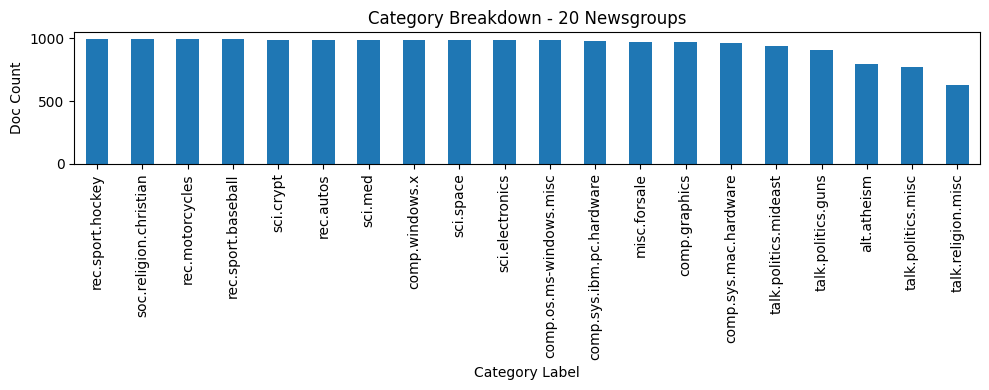

In [ ]:
label_counts = news_df["label"].value_counts()
print(label_counts)
plt.figure(figsize=(10, 4))
label_counts.plot(kind="bar")
plt.title("Category Breakdown - 20 Newsgroups")
plt.xlabel("Category Label")
plt.ylabel("Doc Count")
plt.tight_layout()
plt.show()

In [ ]:

most_common = label_counts.max()
least_common = label_counts.min()

imbalance_ratio = most_common / least_common
print(f"Imbalance ratio (max/min): {imbalance_ratio:.2f}")

Imbalance ratio (max/min): 1.59


**2.1.1 Result**
*  The dataset is not perfectly balanced
*   Imbalance ratio of 1.59 indicates moderate imbalance










**2.1.2 Balancing Method**

The dataset has a mild class imbalance (max/min ≈ 1.59). Instead of using over-sampling or under-sampling, class imbalance is handled using class-weighted learning (class_weight="balanced"). This gives more importance to minority classes while keeping the original data distribution unchanged.

In [ ]:
#Balancing method - Class Weighting
classes = np.unique(news_df["label"])
weights = compute_class_weight(
    class_weight="balanced",
    classes=classes,
    y=news_df["label"]
)

class_weights = dict(zip(classes, weights))
class_weights


{'alt.atheism': np.float64(1.1787859824780975),
 'comp.graphics': np.float64(0.9699794026776519),
 'comp.os.ms-windows.misc': np.float64(0.9571646341463415),
 'comp.sys.ibm.pc.hardware': np.float64(0.960091743119266),
 'comp.sys.mac.hardware': np.float64(0.9800728407908429),
 'comp.windows.x': np.float64(0.9532894736842106),
 'misc.forsale': np.float64(0.9679856115107913),
 'rec.autos': np.float64(0.9513636363636364),
 'rec.motorcycles': np.float64(0.9456325301204819),
 'rec.sport.baseball': np.float64(0.9484894259818731),
 'rec.sport.hockey': np.float64(0.9427927927927928),
 'sci.crypt': np.float64(0.9504036326942482),
 'sci.electronics': np.float64(0.9571646341463415),
 'sci.med': np.float64(0.9513636363636364),
 'sci.space': np.float64(0.9542553191489361),
 'soc.religion.christian': np.float64(0.9446840521564694),
 'talk.politics.guns': np.float64(1.035),
 'talk.politics.mideast': np.float64(1.001968085106383),
 'talk.politics.misc': np.float64(1.215290322580645),
 'talk.religion.mi

**2.2 Word Cloud**

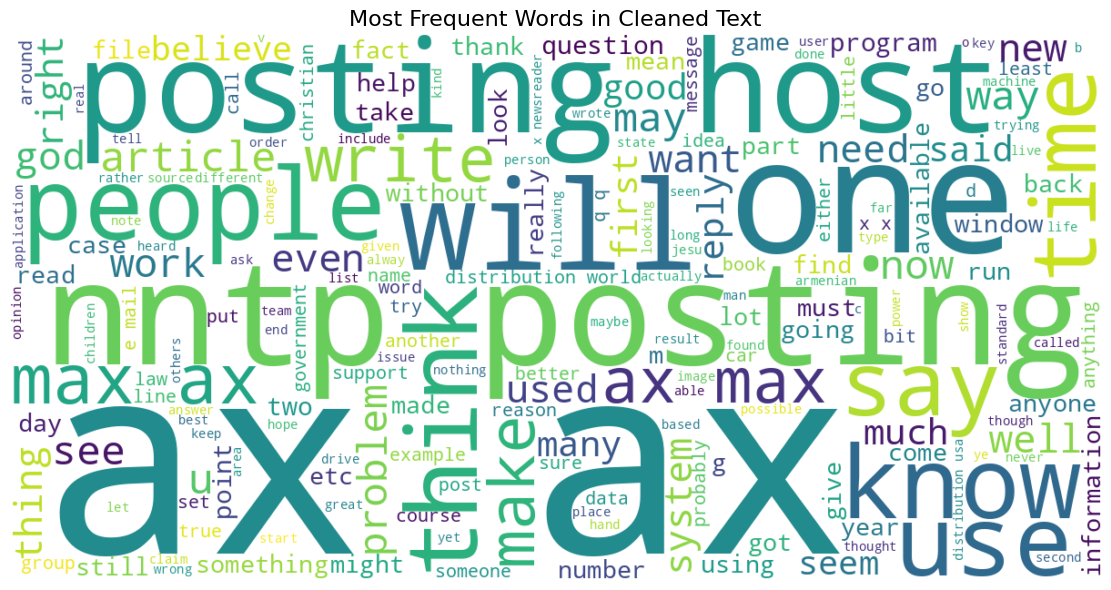

In [ ]:
combined_text = " ".join(news_df["text_clean"])
wc = WordCloud(
    width=1200,
    height=600,
    background_color="white",
    max_words=200,
    colormap='viridis'
).generate(combined_text)

# Plotting the word cloud
plt.figure(figsize=(12, 6))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Most Frequent Words in Cleaned Text", fontsize=16)
plt.tight_layout()
plt.show()

**2.3 Message Length**

We analyze the document length based on the number of tokens, as this is more useful than character count for NLP models.

count    18837.000000
mean       223.213675
std        631.012317
min          1.000000
25%         64.000000
50%        110.000000
75%        200.000000
max      20367.000000
Name: msg_len, dtype: float64


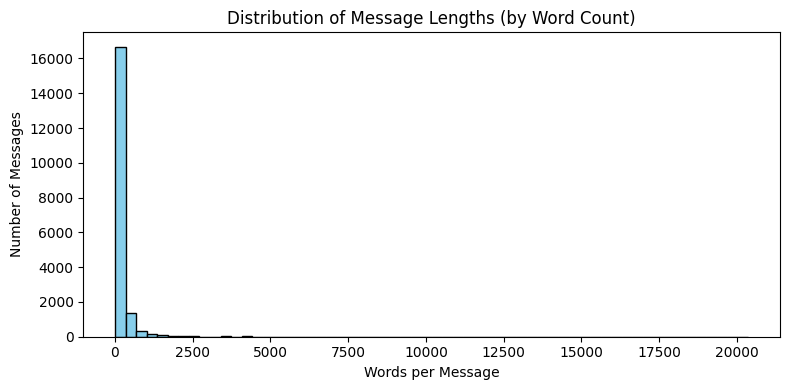

In [ ]:
# Count how many words (tokens) are in each cleaned message
news_df["msg_len"] = news_df["text_clean"].str.split().apply(len)
print(news_df["msg_len"].describe())

# Plotting message lengths
plt.figure(figsize=(8, 4))
plt.hist(news_df["msg_len"], bins=60, color="skyblue", edgecolor="black")
plt.title("Distribution of Message Lengths (by Word Count)")
plt.xlabel("Words per Message")
plt.ylabel("Number of Messages")
plt.tight_layout()
plt.show()

**2.4 Message Length Distribution per Class**

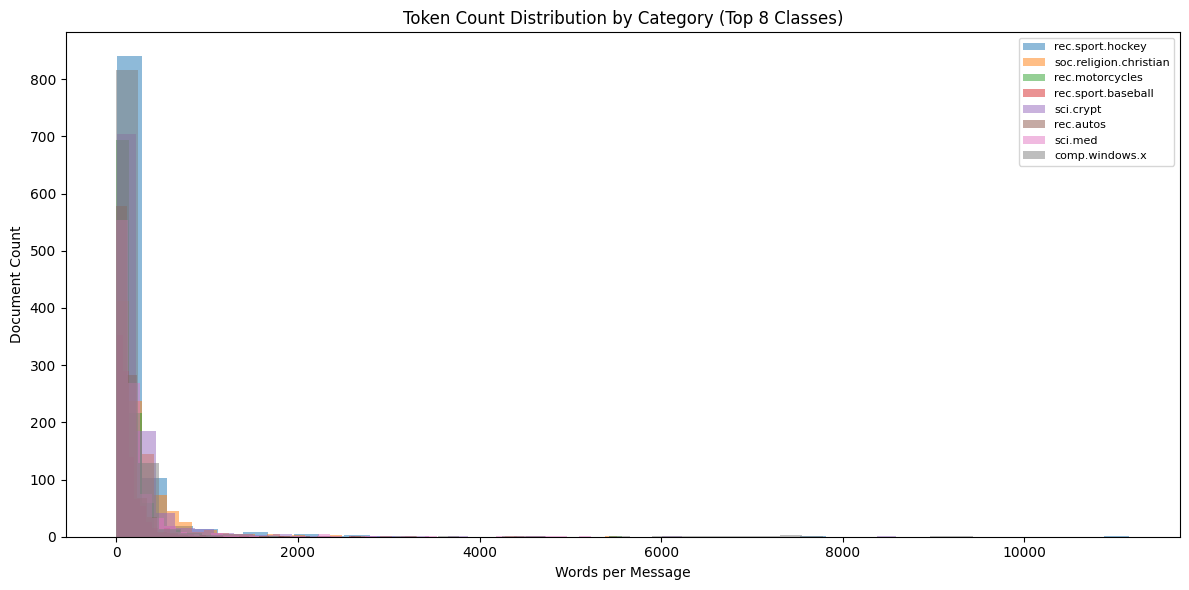

                          count    mean      std  min    25%    50%     75%      max
label                                                                               
alt.atheism               799.0  229.08   485.22  5.0  68.00  123.0  225.50   8722.0
comp.graphics             971.0  229.53   870.62  5.0  57.50   89.0  150.50   9865.0
comp.os.ms-windows.misc   984.0  351.80  1613.45  5.0  55.00   93.5  155.25  20367.0
comp.sys.ibm.pc.hardware  981.0  153.62   253.35  2.0  65.00  104.0  171.00   4252.0
comp.sys.mac.hardware     961.0  135.70   378.18  4.0  60.00   91.0  144.00   8287.0
comp.windows.x            988.0  265.88   890.29  2.0  66.00  111.0  190.00   9433.0
misc.forsale              973.0  129.26   189.64  2.0  49.00   82.0  135.00   2766.0
rec.autos                 990.0  142.74   222.29  2.0  57.00   97.0  163.75   4491.0
rec.motorcycles           996.0  137.74   210.49  2.0  64.00   97.0  161.25   5568.0
rec.sport.baseball        993.0  152.83   190.30  4.0  53.00   94

In [ ]:
# Visualize how message length varies across different classes
plt.figure(figsize=(12, 6))
for cat_label in label_counts.index[:8]:
    class_subset = news_df[news_df["label"] == cat_label]
    plt.hist(
        class_subset["msg_len"],
        bins=40,
        alpha=0.5,
        label=cat_label
    )

plt.title("Token Count Distribution by Category (Top 8 Classes)")
plt.xlabel("Words per Message")
plt.ylabel("Document Count")
plt.legend(fontsize=8)
plt.tight_layout()
plt.show()
length_summary = news_df.groupby("label")["msg_len"].describe().round(2)
print(length_summary)

# **3. Feature Engineering**
This section explains the feature engineering methods and classification models used in this work. Three different approaches are applied to see how different text representations affect classification performance. The models used range from simple count-based methods to embedding-based methods. The implemented models are

*   One-hot (Bag-of-Words) representation
*   TF-IDF
*   Word2Vec embeddings





**3.1 Train–Test Split**

In [ ]:

texts = news_df["text_clean"].values
labels = news_df["label"].values
X_train, X_test, y_train, y_test = train_test_split(
    texts,
    labels,
    test_size=0.2,
    random_state=42,
    stratify=labels
)
print("Training set size:", len(X_train))
print("Test set size:", len(X_test))

Training set size: 15069
Test set size: 3768


**3.2 One-hot Encoding (Bag-of-Words) with Logistic Regression**

In the Bag-of-Words method, each document is represented as a binary vector that shows whether a word is present in the document or not. This method does not consider the order of words.

In [ ]:
bow_vectorizer = CountVectorizer(binary=True, min_df=2)

# Transform the train and test data separately
X_train_bow = bow_vectorizer.fit_transform(X_train)
X_test_bow = bow_vectorizer.transform(X_test)

# Train a basic logistic regression classifier
logreg_model = LogisticRegression(
    max_iter=2000,
    class_weight=class_weights
)
logreg_model.fit(X_train_bow, y_train)
y_pred_bow = logreg_model.predict(X_test_bow)
# Display performance
print("BoW + Logistic Regression Performance:")
print(classification_report(y_test, y_pred_bow, zero_division=0))

BoW + Logistic Regression Performance:
                          precision    recall  f1-score   support

             alt.atheism       0.77      0.77      0.77       160
           comp.graphics       0.73      0.75      0.74       194
 comp.os.ms-windows.misc       0.72      0.75      0.73       197
comp.sys.ibm.pc.hardware       0.74      0.68      0.71       196
   comp.sys.mac.hardware       0.74      0.79      0.76       192
          comp.windows.x       0.82      0.83      0.82       198
            misc.forsale       0.77      0.85      0.81       195
               rec.autos       0.80      0.80      0.80       198
         rec.motorcycles       0.92      0.80      0.85       199
      rec.sport.baseball       0.83      0.89      0.86       199
        rec.sport.hockey       0.93      0.90      0.92       200
               sci.crypt       0.90      0.89      0.89       198
         sci.electronics       0.74      0.75      0.75       197
                 sci.med       0.83 

**3.3 TF-IDF Representation + Linear SVM**
  
TF-IDF assigns weights to words based on how important they are in a document compared to the whole dataset. It reduces the effect of very common words and helps in better distinguishing between classes.

In [ ]:
# Setting up TF-IDF with unigrams and bigrams
tfidf_vectorizer = TfidfVectorizer(
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.9
)

# Transform the training and test sets
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)
svm_model = LinearSVC(class_weight=class_weights)
svm_model.fit(X_train_tfidf, y_train)
# Make predictions
y_pred_tfidf = svm_model.predict(X_test_tfidf)
# Print out a basic performance report
print("TF-IDF + Linear SVM Results:")
print(classification_report(y_test, y_pred_tfidf, zero_division=0))

TF-IDF + Linear SVM Results:
                          precision    recall  f1-score   support

             alt.atheism       0.88      0.87      0.87       160
           comp.graphics       0.84      0.82      0.83       194
 comp.os.ms-windows.misc       0.85      0.82      0.83       197
comp.sys.ibm.pc.hardware       0.82      0.80      0.81       196
   comp.sys.mac.hardware       0.81      0.82      0.82       192
          comp.windows.x       0.87      0.90      0.89       198
            misc.forsale       0.79      0.89      0.83       195
               rec.autos       0.88      0.87      0.88       198
         rec.motorcycles       0.97      0.90      0.94       199
      rec.sport.baseball       0.91      0.91      0.91       199
        rec.sport.hockey       0.96      0.96      0.96       200
               sci.crypt       0.93      0.94      0.94       198
         sci.electronics       0.84      0.83      0.84       197
                 sci.med       0.91      0.92 

**3.3 Word2Vec Embeddings + Logistic Regression**

Word2Vec learns dense vector representations of words based on their surrounding context. For document-level representation, the word embeddings are averaged for each document.

In [ ]:

# Tokenize each document
tokenized_corpus = [doc.split() for doc in X_train]
# Train the Word2Vec model
w2v_model = Word2Vec(
    sentences=tokenized_corpus,
    vector_size=100,
    window=5,
    min_count=2,
    workers=4,
    seed=42
)

# Helper to turn a doc into a vector
def get_doc_embedding(doc, model):
    words = doc.split()
    vectors = [model.wv[w] for w in words if w in model.wv]

    # If none of the words are in the vocab, return a zero vector
    if not vectors:
        return np.zeros(model.vector_size)

    return np.mean(vectors, axis=0)

# Create document vectors for both train and test sets
X_train_w2v = np.vstack([get_doc_embedding(doc, w2v_model) for doc in X_train])
X_test_w2v = np.vstack([get_doc_embedding(doc, w2v_model) for doc in X_test])

# Train a simple logistic regression model on top of the averaged vectors
logreg_w2v = LogisticRegression(
    max_iter=2000,
    class_weight=class_weights
)
logreg_w2v.fit(X_train_w2v, y_train)

# Make predictions on the test set
y_pred_w2v = logreg_w2v.predict(X_test_w2v)

# Display performance
print("Word2Vec + Logistic Regression Results:")
print(classification_report(y_test, y_pred_w2v, zero_division=0))

Word2Vec + Logistic Regression Results:
                          precision    recall  f1-score   support

             alt.atheism       0.36      0.29      0.32       160
           comp.graphics       0.46      0.49      0.48       194
 comp.os.ms-windows.misc       0.55      0.48      0.51       197
comp.sys.ibm.pc.hardware       0.46      0.44      0.45       196
   comp.sys.mac.hardware       0.35      0.31      0.33       192
          comp.windows.x       0.65      0.67      0.66       198
            misc.forsale       0.69      0.72      0.71       195
               rec.autos       0.45      0.41      0.43       198
         rec.motorcycles       0.45      0.49      0.47       199
      rec.sport.baseball       0.52      0.46      0.49       199
        rec.sport.hockey       0.65      0.65      0.65       200
               sci.crypt       0.68      0.64      0.66       198
         sci.electronics       0.40      0.37      0.38       197
                 sci.med       0.50

# **4. Comparison Table**

In [ ]:

def evaluate_model(y_true, y_pred, model_name):
    acc = accuracy_score(y_true, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true,
        y_pred,
        average="weighted",
        zero_division=0
    )
    return {
        "Model": model_name,
        "Accuracy": acc,
        "Precision (Weighted)": precision,
        "Recall (Weighted)": recall,
        "F1-score (Weighted)": f1
    }

eval_results = []
eval_results.append(evaluate_model(y_test, y_pred_bow, "BoW + Logistic Regression"))
eval_results.append(evaluate_model(y_test, y_pred_tfidf, "TF-IDF + Linear SVM"))
eval_results.append(evaluate_model(y_test, y_pred_w2v, "Word2Vec + Logistic Regression"))

# Turn the collected results into a DataFrame for comparison
results_table = pd.DataFrame(eval_results)
results_table = results_table.sort_values(
    by="F1-score (Weighted)",
    ascending=False
)
pd.set_option("display.expand_frame_repr", False)
pd.set_option("display.max_columns", None)
print("Model Comparison Summary:")
display(results_table)

Model Comparison Summary:


,Model,Accuracy,Precision (Weighted),Recall (Weighted),F1-score (Weighted)
1,TF-IDF + Linear SVM,0.874204,0.874621,0.874204,0.873729
0,BoW + Logistic Regression,0.803079,0.804712,0.803079,0.803100
2,Word2Vec + Logistic Regression,0.503185,0.498454,0.503185,0.499250


# **Result**

Table shows the performance comparison of the three models using different evaluation metrics. Among all models, TF-IDF with Linear SVM gives the best accuracy and weighted F1-score, showing that it works well for multi-class topic classification. The Bag-of-Words model with Logistic Regression gives good baseline results but is limited due to its sparse and non-semantic nature. The Word2Vec-based model performs much worse, mainly because important information is lost when word embeddings are averaged at the document level. Overall, the results show that TF-IDF is very effective for topic-based text classification tasks.

In [ ]:
!jupyter nbconvert --to html /content/BigDataAnalytics.ipynb


[NbConvertApp] Converting notebook /content/BigDataAnalytics.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 4 image(s).
[NbConvertApp] Writing 1139921 bytes to /content/BigDataAnalytics.html
